<a href="https://colab.research.google.com/github/Walbyq/mobilenetv2-unet-segmentation/blob/main/notebooks/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка датасета

Подключение к Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Объявление словаря цветов

In [ ]:
# Словарь соответствия цветов классам
color_to_class = {
    (0, 0, 0): 0,    # черный - фон
    (255, 255, 255): 1,  # белый - корпус автомобиля
    (255, 0, 0): 2,  # красный - окна
    (0, 255, 0): 3,  # зеленый - фары
    (0, 0, 255): 4   # синий - колеса
}

num_classes = len(color_to_class)

Загрузка изображений и масок из Google Colab

In [ ]:
import cv2
from glob import glob

# Функция загрузки изображений
def load_images(path):
    image_paths = sorted(glob(path))
    return [cv2.imread(path) for path in image_paths]

# Путь к данным
data_path = "/content/drive/MyDrive/car_dataset/"

# Загрузка изображений и масок
images = load_images(data_path + "images/*.png")
masks = load_images(data_path + "masks/*.png")

Предобработка данных

In [ ]:
!pip install -U albumentations

import numpy as np
import albumentations as A
from sklearn.model_selection import train_test_split

# Функция аугментации данных
def augment_data(images, masks):
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Transpose(p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.2),
        A.Rotate(limit=30, p=0.5),
        A.ElasticTransform(p=0.2),
        A.GridDistortion(p=0.2),
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.2),
    ])

    augmented = [augmentation(image=image, mask=mask) for image, mask in zip(images, masks)]
    return np.array([a['image'] for a in augmented]), np.array([a['mask'] for a in augmented])

# Функция подготовки данных
def preprocess_data(images, masks, num_classes, color_to_class):

    # Предварительная обработка изображений и масок
    processed_images = np.array([cv2.resize(img, (256, 256)) for img in images]) / 255.0
    processed_masks = np.array([cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) for mask in masks])

    # Векторизация масок по заданному словарю соответствия
    vectorized_color_to_class = np.vectorize(lambda r, g, b: color_to_class[(r, g, b)])
    processed_masks = vectorized_color_to_class(processed_masks[:,:,:,0], processed_masks[:,:,:,1], processed_masks[:,:,:,2])

    # Преобразование в one-hot encoding
    processed_masks = np.eye(num_classes)[processed_masks]

    return processed_images, processed_masks

# Функция деления датасета на обучающую и валидационную выборки
def prepare_dataset(images, masks, num_classes, color_to_class, test_size=0.2, augment=True):
    X, y = preprocess_data(images, masks, num_classes, color_to_class)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    if augment:
        X_train_aug, y_train_aug = augment_data(X_train, y_train)
        X_train = np.concatenate([X_train, X_train_aug])
        y_train = np.concatenate([y_train, y_train_aug])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_dataset(images, masks, num_classes, color_to_class)

# Сравнение объема датасета до и после аугментации
print("Количество изображений до аугментации: ", len(images))
print("Количество изображений после аугментации: ", X_train.shape[0] + X_test.shape[0])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15
Количество изображений до аугментации:  211
Количество изображений после аугментации:  379


## Обучение модели

Определение функция метрик и потерь

In [ ]:
from tensorflow.keras import backend as K

# Добавление метрики IoU
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

# Добавление метрики Dice
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

# Комбинированная функция потерь
def combined_loss(y_true, y_pred):
    return 0.5 * K.binary_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_coef(y_true, y_pred))

Создание модели

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

# Функция создания модели
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Энкодер (используем предобученную MobileNetV2)
    base_model = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False)

    # Получаем промежуточные выходы для skip-connections
    skip_connections = [
        base_model.get_layer('block_1_expand_relu').output,  # 128x128
        base_model.get_layer('block_3_expand_relu').output,  # 64x64
        base_model.get_layer('block_6_expand_relu').output,  # 32x32
        base_model.get_layer('block_13_expand_relu').output, # 16x16
    ]

    # Декодер
    x = base_model.output

    for i, skip in enumerate(reversed(skip_connections)):
        x = UpSampling2D(size=(2, 2))(x)
        x = Concatenate()([x, skip])
        x = Conv2D(256//(2**i), 3, padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.3)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, 3, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Создание и компиляция модели
model = create_model((256, 256, 3), num_classes)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=combined_loss,
              metrics=['accuracy', iou_coef, dice_coef])

<ipython-input-5-946e50d8430f>:30: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False)


Обучение и сохранение модели

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Параметры обучения
epochs = 300
batch_size = 16

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(patience=20, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6)
    ]
)

# Сохранение модели на Google Drive
model.save('/content/drive/My Drive/segmentation_model.keras')
!ls -l "/content/drive/My Drive/segmentation_model.keras"

Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 106s 832ms/step - accuracy: 0.5264 - dice_coef: 0.3558 - iou_coef: 0.2178 - loss: 0.6118 - val_accuracy: 0.2566 - val_dice_coef: 0.2979 - val_iou_coef: 0.1770 - val_loss: 0.8124 - learning_rate: 1.0000e-04
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7292 - dice_coef: 0.5002 - iou_coef: 0.3357 - loss: 0.4762 - val_accuracy: 0.3855 - val_dice_coef: 0.3606 - val_iou_coef: 0.2227 - val_loss: 0.7844 - learning_rate: 1.0000e-04
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.8327 - dice_coef: 0.6040 - iou_coef: 0.4339 - loss: 0.3843 - val_accuracy: 0.5814 - val_dice_coef: 0.4842 - val_iou_coef: 0.3256 - val_loss: 0.6096 - learning_rate: 1.0000e-04
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.8896 - dice_coef: 0.6753 - iou_coef: 0.5108 - loss: 0.3215 - val_accuracy: 0.7203 - val_dice_coef: 0.5486 - val_iou_coef: 0.3851 - val_loss: 0.5108 - learning_rate: 1.0000e-04
Epoch 5/300
21/21 ━━━━━━━━

Визуализация процесса обучения

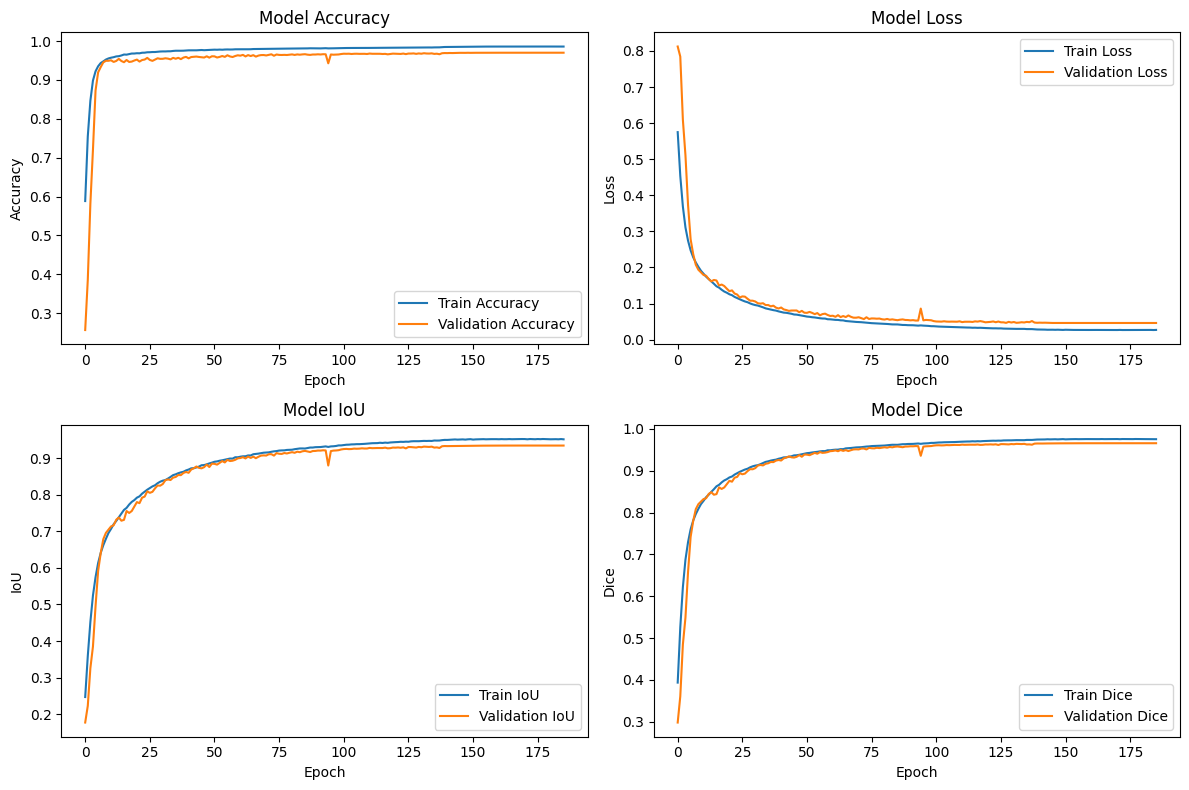

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# График точности
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График IoU
plt.subplot(2, 2, 3)
plt.plot(history.history['iou_coef'], label='Train IoU')
plt.plot(history.history['val_iou_coef'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

# График Dice
plt.subplot(2, 2, 4)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Validation Dice')
plt.title('Model Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()

## Загрузка модели

In [ ]:
from tensorflow.keras.models import load_model

# Указываем путь к модели
model_path = '/content/drive/My Drive/segmentation_model.keras'

# Загрузка модели
model = load_model(model_path, custom_objects={
    'iou_coef': iou_coef,
    'dice_coef': dice_coef,
    'combined_loss': combined_loss
})

# Оценка и предсказание модели

Оценка модели на тестовых данных

In [ ]:
# Оценка
test_loss, test_accuracy, test_iou, test_dice = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.9703 - dice_coef: 0.9657 - iou_coef: 0.9349 - loss: 0.0456
Test Accuracy: 0.9699
Test IoU: 0.9335
Test Dice: 0.9649
Test Loss: 0.0460


Улучшение видимости границ изображений

In [ ]:
# Функция для улучшения видимости границ
def enhance_boundaries(image):

    # Преобразование изображения в тип uint8
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Конвертация в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применение адаптивной эквализации гистограммы
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(gray)

    # Применение фильтра Гаусса для уменьшения шума
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    # Применение фильтра Собеля для выделения краев
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobelx**2 + sobely**2)

    # Нормализация и преобразование в uint8
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Наложение краев на оригинальное изображение
    result = cv2.addWeighted(image, 0.7, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.3, 0)

    return result

# Применение функции к изображениям в наборе данных
enhanced_images = [enhance_boundaries(img) for img in X_test]

Визуализация результатов на новых изображениях

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


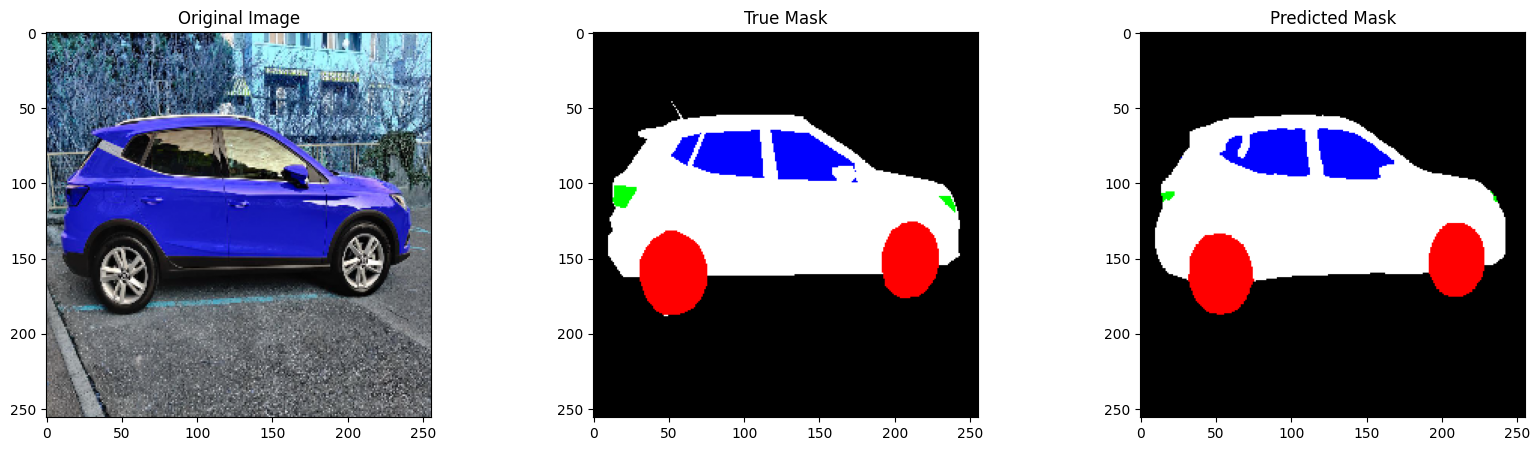

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


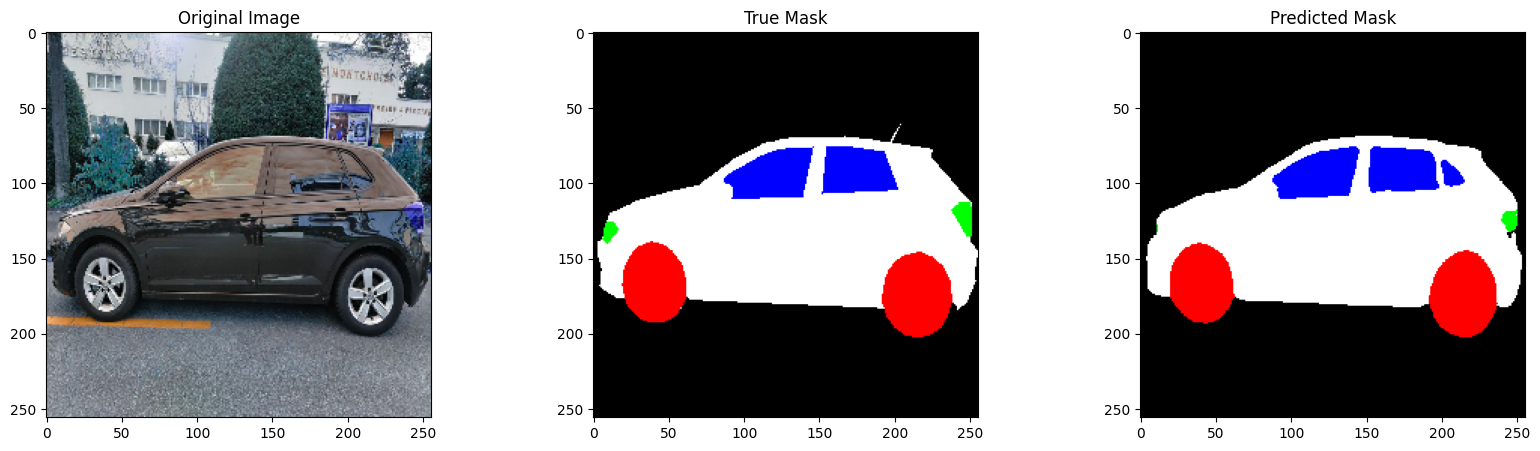

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


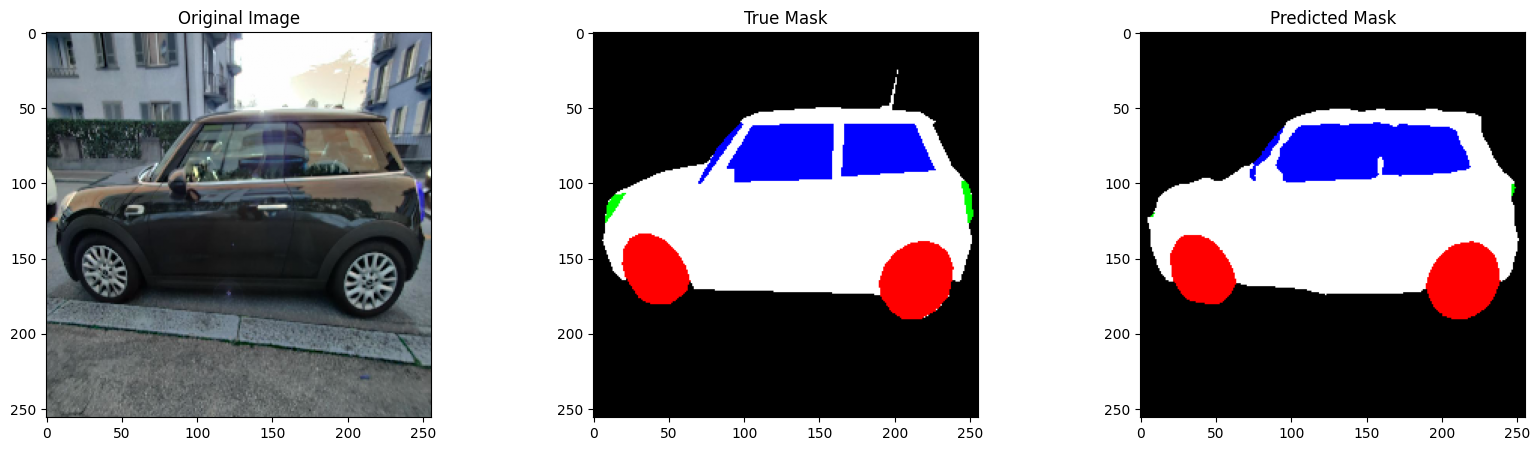

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


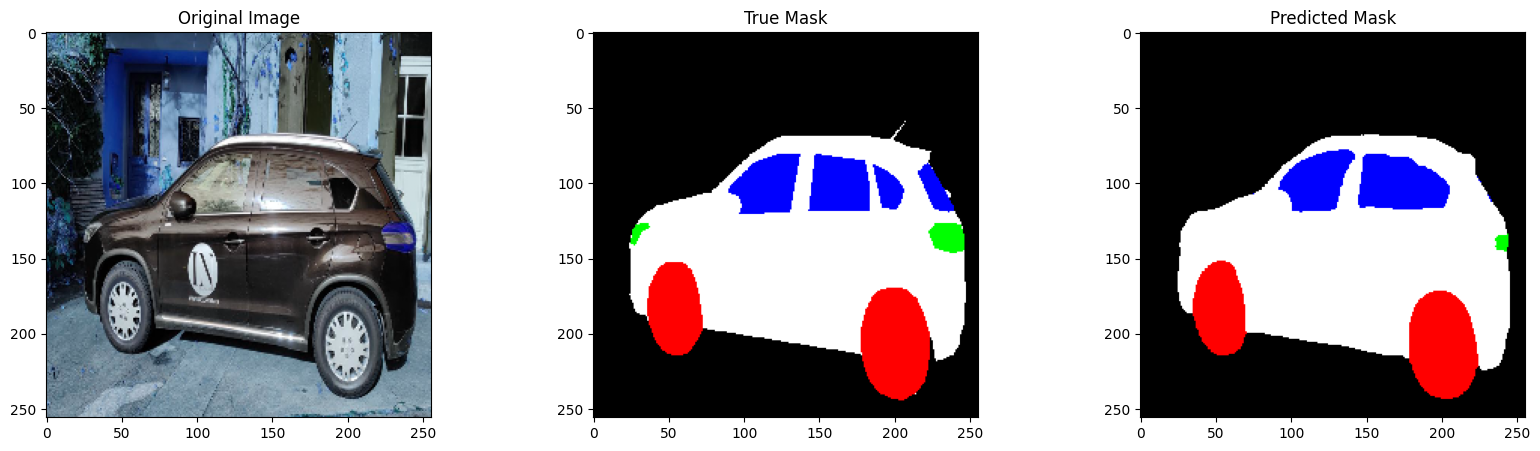

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


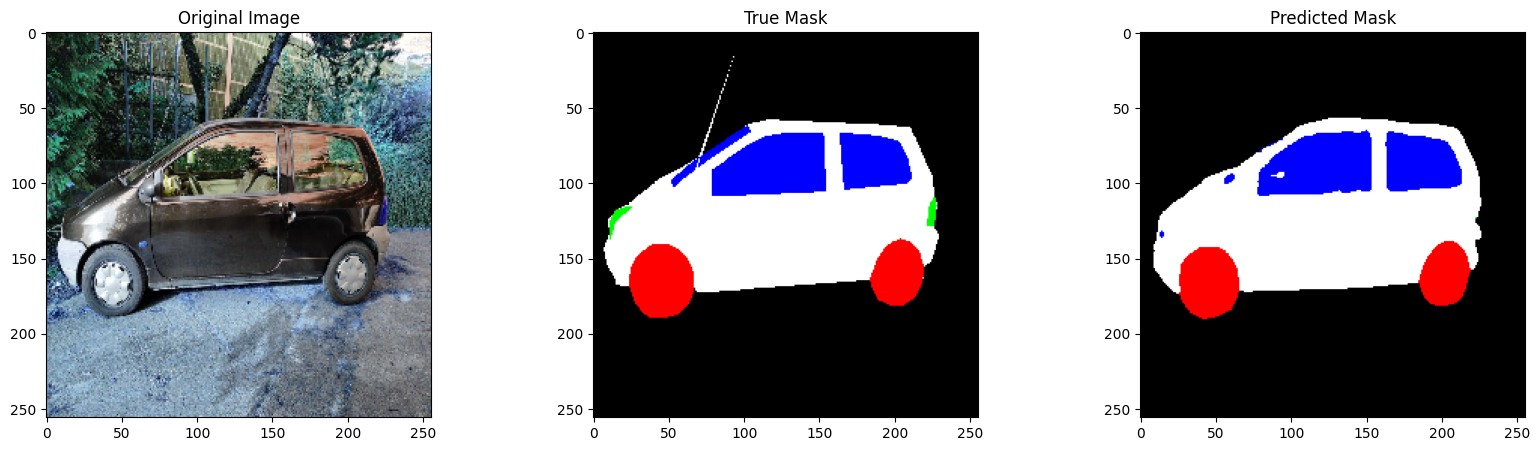

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


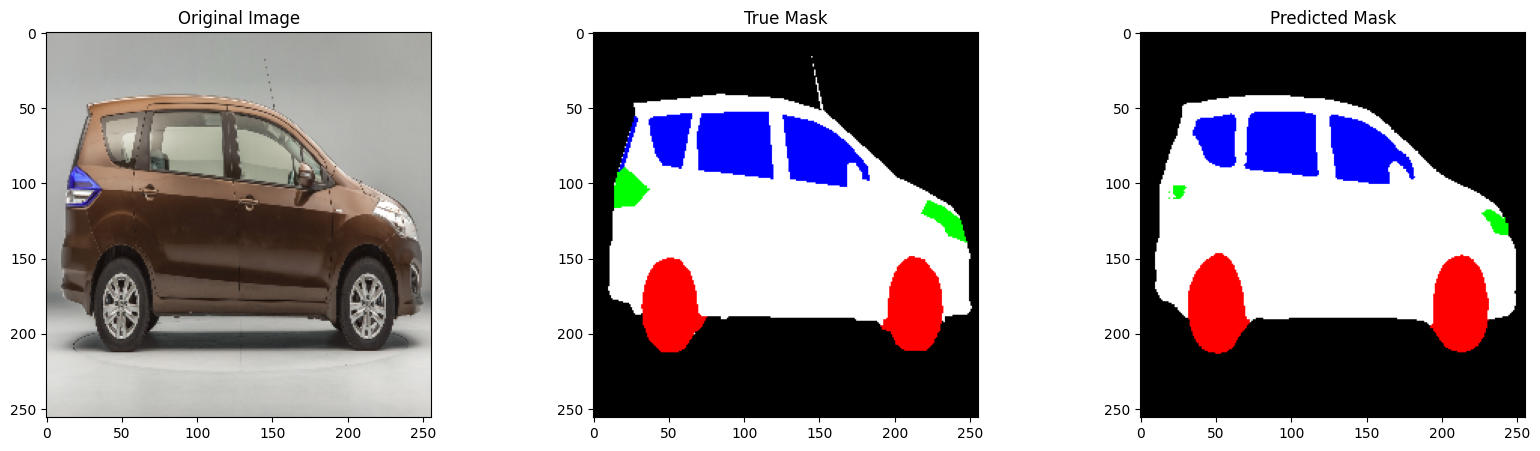

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


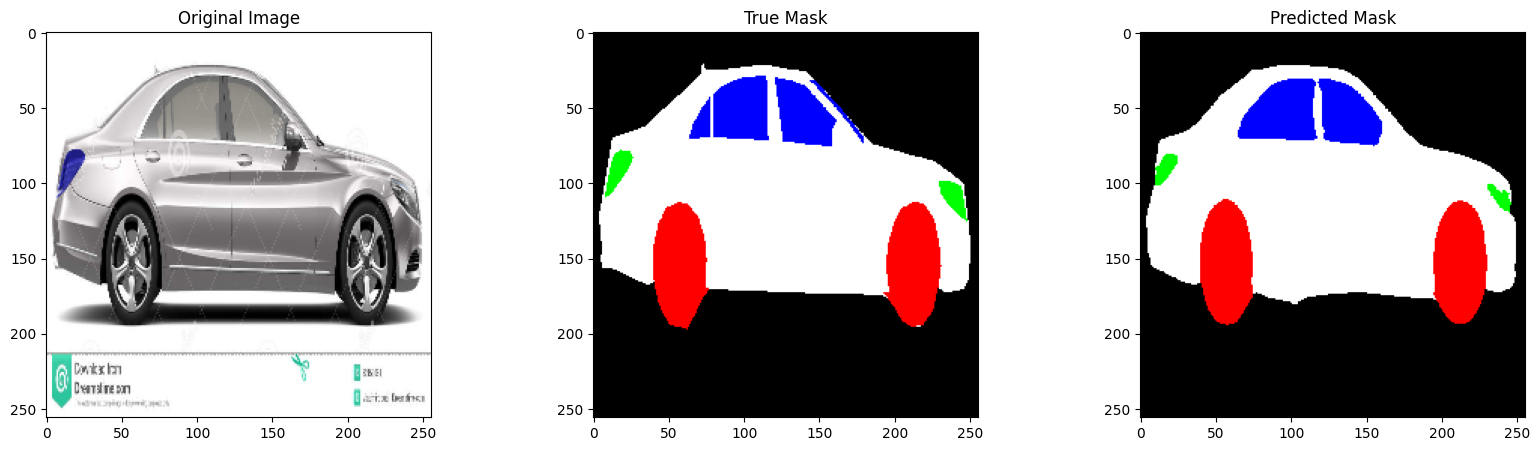

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


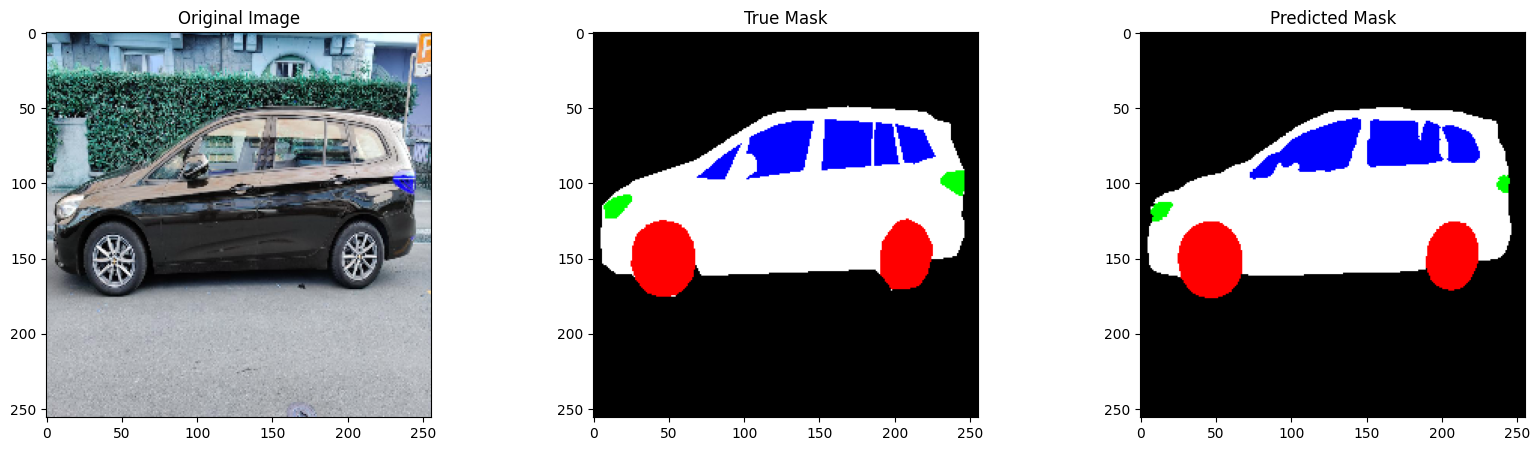

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


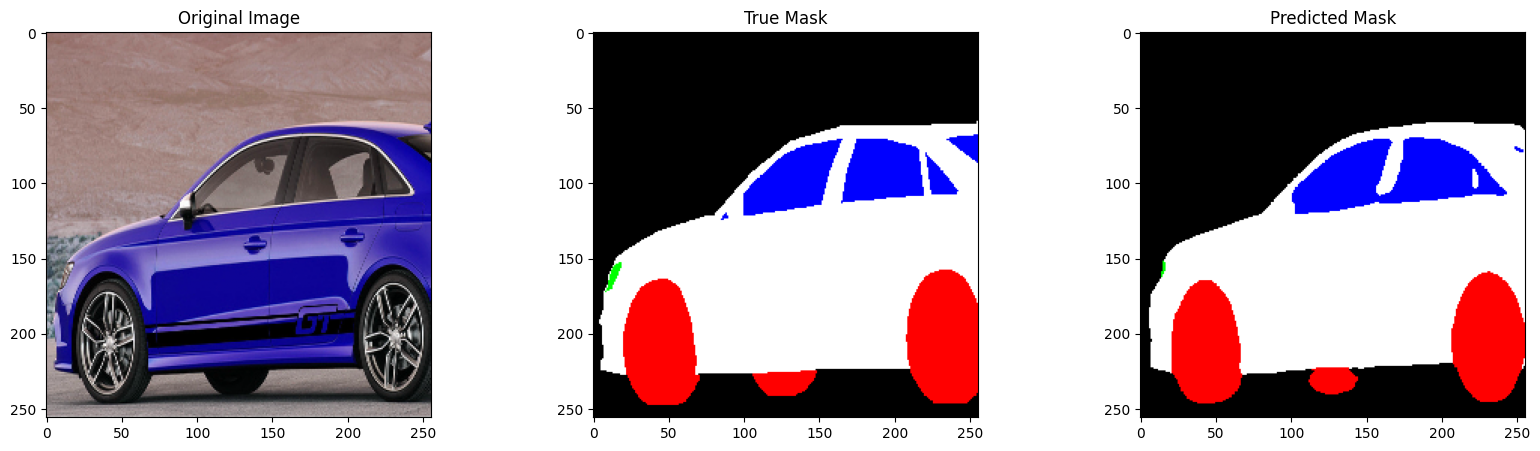

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


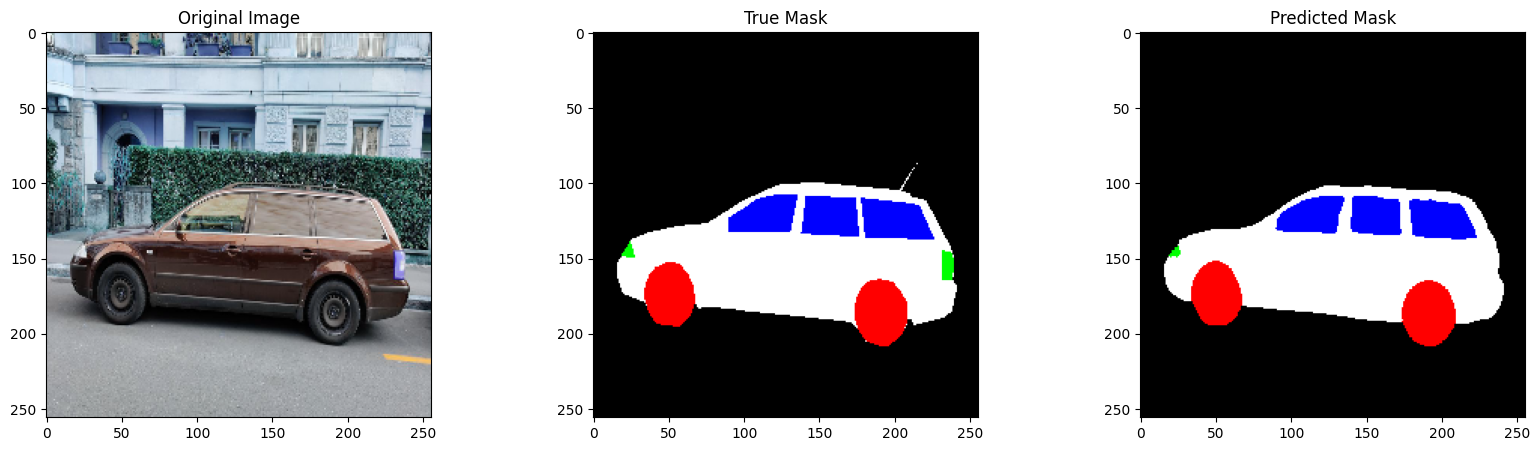

In [ ]:
# Функция визуализации результатов
def visualize_results(image, true_mask, predicted_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    def create_color_mask(mask):
        color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for color, class_num in color_to_class.items():
            color_mask[mask == class_num] = color
        return color_mask

    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(create_color_mask(true_mask))
    ax2.set_title('True Mask')
    ax3.imshow(create_color_mask(predicted_mask))
    ax3.set_title('Predicted Mask')
    plt.show()

# Визуализация результатов
for i in range(30, 40):
    test_image = X_test[i]
    true_mask = np.argmax(y_test[i], axis=-1)

    # Получаем предсказания модели
    predicted_probs = model.predict(test_image[np.newaxis, ...])[0]
    predicted_mask = np.argmax(predicted_probs, axis=-1)

    visualize_results(test_image, true_mask, predicted_mask)